In [34]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os
# from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms
from torchinfo import summary
import timm

In [35]:
!nvidia-smi
!nvidia-smi -L

Sun Nov 24 07:39:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             28W /   70W |    3445MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [37]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower_red1 = np.array([0, 100, 20])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160,100,20])
        upper_red2 = np.array([179,255,255])
        
        lower_mask_red = cv2.inRange(image, lower_red1, upper_red1)
        upper_mask_red = cv2.inRange(image, lower_red2, upper_red2)
        
        red_mask = lower_mask_red + upper_mask_red
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  #  BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB
        label = self.read_mask(label_path)  
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [38]:
image_path = []
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [39]:
mask_path = []
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    #iterate over 1000 masks
    for file in files:
        # obtain the path"
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)

1000

In [40]:
dataset = CustomImageDataset(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (256,256),
                             transform = None)

In [41]:
!pip install segmentation-models-pytorch


In [43]:
import segmentation_models_pytorch as smp


model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

In [44]:
batch_size = 8
images_data = []
labels_data = []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

In [47]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label
    def __len__(self):
        return len(self.data)

    
train_transformation = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.4),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transformation = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])
# Split the dataset into training and validation sets
train_size = int(0.8 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)
# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

800
200


/tmp/ipykernel_30/1058005291.py:23: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),


Image:  torch.Size([3, 256, 256]) Label:  torch.Size([1, 256, 256])


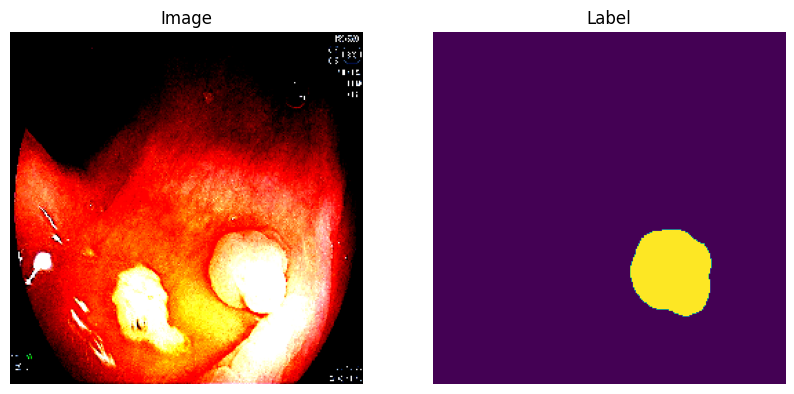

In [48]:
image,label = train_dataset[2]
print('Image: ', image.shape, 'Label: ', label.shape)

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')  

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')  

plt.show()

In [49]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
#     print(output.shape)
    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

In [51]:
import wandb
PROJECT = "deep-homework"
RESUME = "allow"
WANDB_KEY = "626a895d3032d1de89568d5eb599298b39db1c48"
wandb.login(
    # set the wandb project where this run will be logged
#     project= "PolypSegment", 
    key =WANDB_KEY,
)
wandb.init(
    project=PROJECT,
    resume=RESUME,
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Train_loss,▆▅▅▅▃▃▃▂▃▃▂▂▁▆▃▂▂▂▂▁▁█▂▁▁▁▁▃▂▁▁▂▂▁▁▁▁▁▁▁
Val_loss,▁▂▃▃▂▃▂▅▃▅▄▄▅▅▇▅▄▄▆▃▅▆▆▆▆▄▅▅▅▅▅▇▇▇▇▅▇█▄▅
Train_loss,0.00235
Val_loss,0.0952


In [53]:
!pip install tqdm


# Move the model to the device (e.g., GPU)
from tqdm import tqdm
import time

num_epochs = 250

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
best_val_loss = 999

epoch_bar = tqdm(total=num_epochs, desc='Total Progress')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels.squeeze(dim=1).long()
        outputs = model(images)
    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()
            
            outputs = model(images)

            val_loss += criterion(outputs.float(),labels.long()).item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        save_path = f'model3.pth'
        torch.save(checkpoint, save_path)
        
    epoch_bar.update(1)
    wandb.log({'Val_loss': val_loss/len(val_loader),'Train_loss': train_loss/len(train_loader)})
epoch_bar.close()


Total Progress:   1%|          | 2/250 [01:21<2:49:24, 40.99s/it]


Epoch [1/250], Loss: 0.1482613134



Total Progress:   0%|          | 1/250 [00:27<1:55:27, 27.82s/it]

Epoch [2/250], Loss: 0.1105351472



Total Progress:   1%|          | 2/250 [00:56<1:57:19, 28.38s/it]

Epoch [3/250], Loss: 0.0928025040



Total Progress:   1%|          | 3/250 [01:24<1:56:00, 28.18s/it]

Epoch [4/250], Loss: 0.0812961642



Total Progress:   2%|▏         | 4/250 [01:52<1:55:44, 28.23s/it]

Epoch [5/250], Loss: 0.0722055560



Total Progress:   2%|▏         | 5/250 [02:21<1:55:32, 28.29s/it]

Epoch [6/250], Loss: 0.0632676722



Total Progress:   3%|▎         | 7/250 [03:16<1:53:27, 28.01s/it]

Epoch [7/250], Loss: 0.0779797907
Epoch [8/250], Loss: 0.0564834448



Total Progress:   4%|▎         | 9/250 [04:12<1:52:05, 27.91s/it]

Epoch [9/250], Loss: 0.0594664105



Total Progress:   4%|▍         | 10/250 [04:40<1:51:05, 27.77s/it]

Epoch [10/250], Loss: 0.0630296194



Total Progress:   4%|▍         | 11/250 [05:07<1:50:16, 27.68s/it]

Epoch [11/250], Loss: 0.0595338935



Total Progress:   5%|▍         | 12/250 [05:35<1:49:34, 27.62s/it]

Epoch [12/250], Loss: 0.0586534506
Epoch [13/250], Loss: 0.0553422458



Total Progress:   6%|▌         | 14/250 [06:31<1:49:05, 27.73s/it]

Epoch [14/250], Loss: 0.0572429891



Total Progress:   6%|▌         | 15/250 [06:58<1:48:14, 27.64s/it]

Epoch [15/250], Loss: 0.0677138247
Epoch [16/250], Loss: 0.0543323508



Total Progress:   6%|▋         | 16/250 [07:26<1:48:32, 27.83s/it]

Epoch [17/250], Loss: 0.0525743682



Total Progress:   7%|▋         | 17/250 [07:55<1:48:36, 27.97s/it]

Epoch [18/250], Loss: 0.0523084161



Total Progress:   8%|▊         | 19/250 [08:50<1:47:27, 27.91s/it]

Epoch [19/250], Loss: 0.0561512270



Total Progress:   8%|▊         | 20/250 [09:18<1:46:31, 27.79s/it]

Epoch [20/250], Loss: 0.0537757147



Total Progress:   8%|▊         | 21/250 [09:45<1:45:39, 27.68s/it]

Epoch [21/250], Loss: 0.0524902454



Total Progress:   9%|▉         | 22/250 [10:13<1:44:59, 27.63s/it]

Epoch [22/250], Loss: 0.0594951136



Total Progress:   9%|▉         | 23/250 [10:40<1:44:20, 27.58s/it]

Epoch [23/250], Loss: 0.0594131840



Total Progress:  10%|▉         | 24/250 [11:08<1:43:44, 27.54s/it]

Epoch [24/250], Loss: 0.0617062246



Total Progress:  10%|█         | 25/250 [11:35<1:43:10, 27.51s/it]

Epoch [25/250], Loss: 0.0585782018



Total Progress:  10%|█         | 26/250 [12:03<1:42:32, 27.47s/it]

Epoch [26/250], Loss: 0.0577397138



Total Progress:  11%|█         | 27/250 [12:30<1:42:06, 27.47s/it]

Epoch [27/250], Loss: 0.0778763456



Total Progress:  11%|█         | 28/250 [12:58<1:41:43, 27.49s/it]

Epoch [28/250], Loss: 0.0613526077



Total Progress:  12%|█▏        | 29/250 [13:25<1:41:14, 27.49s/it]

Epoch [29/250], Loss: 0.0551367816



Total Progress:  12%|█▏        | 30/250 [13:52<1:40:45, 27.48s/it]

Epoch [30/250], Loss: 0.0700578126



Total Progress:  12%|█▏        | 31/250 [14:20<1:40:15, 27.47s/it]

Epoch [31/250], Loss: 0.0529476333



Total Progress:  13%|█▎        | 32/250 [14:47<1:39:43, 27.45s/it]

Epoch [32/250], Loss: 0.0585006459



Total Progress:  13%|█▎        | 33/250 [15:15<1:39:22, 27.48s/it]

Epoch [33/250], Loss: 0.0542933038



Total Progress:  14%|█▎        | 34/250 [15:42<1:38:57, 27.49s/it]

Epoch [34/250], Loss: 0.0615793326



Total Progress:  14%|█▍        | 35/250 [16:10<1:38:28, 27.48s/it]

Epoch [35/250], Loss: 0.0636452014



Total Progress:  14%|█▍        | 36/250 [16:37<1:38:02, 27.49s/it]

Epoch [36/250], Loss: 0.0604005003



Total Progress:  15%|█▍        | 37/250 [17:05<1:37:33, 27.48s/it]

Epoch [37/250], Loss: 0.0673856036



Total Progress:  15%|█▌        | 38/250 [17:32<1:37:07, 27.49s/it]

Epoch [38/250], Loss: 0.0689668601



Total Progress:  16%|█▌        | 39/250 [18:00<1:36:42, 27.50s/it]

Epoch [39/250], Loss: 0.0620105453



Total Progress:  16%|█▌        | 40/250 [18:27<1:36:13, 27.49s/it]

Epoch [40/250], Loss: 0.0615258517



Total Progress:  16%|█▋        | 41/250 [18:55<1:35:46, 27.50s/it]

Epoch [41/250], Loss: 0.0616278127



Total Progress:  17%|█▋        | 42/250 [19:22<1:35:20, 27.50s/it]

Epoch [42/250], Loss: 0.0663520542



Total Progress:  17%|█▋        | 43/250 [19:50<1:34:49, 27.49s/it]

Epoch [43/250], Loss: 0.0645155046



Total Progress:  18%|█▊        | 44/250 [20:17<1:34:28, 27.52s/it]

Epoch [44/250], Loss: 0.0591686284



Total Progress:  18%|█▊        | 45/250 [20:45<1:34:01, 27.52s/it]

Epoch [45/250], Loss: 0.0609496369



Total Progress:  18%|█▊        | 46/250 [21:12<1:33:36, 27.53s/it]

Epoch [46/250], Loss: 0.0621853591



Total Progress:  19%|█▉        | 47/250 [21:40<1:33:10, 27.54s/it]

Epoch [47/250], Loss: 0.0726815702



Total Progress:  19%|█▉        | 48/250 [22:08<1:32:39, 27.52s/it]

Epoch [48/250], Loss: 0.0637262680



Total Progress:  20%|█▉        | 49/250 [22:35<1:32:07, 27.50s/it]

Epoch [49/250], Loss: 0.0645509052



Total Progress:  20%|██        | 50/250 [23:03<1:31:43, 27.52s/it]

Epoch [50/250], Loss: 0.0640544775



Total Progress:  20%|██        | 51/250 [23:30<1:31:20, 27.54s/it]

Epoch [51/250], Loss: 0.0627998905



Total Progress:  21%|██        | 52/250 [23:58<1:30:57, 27.56s/it]

Epoch [52/250], Loss: 0.0619383130



Total Progress:  21%|██        | 53/250 [24:25<1:30:29, 27.56s/it]

Epoch [53/250], Loss: 0.0631875875



Total Progress:  22%|██▏       | 54/250 [24:53<1:29:57, 27.54s/it]

Epoch [54/250], Loss: 0.0638622183



Total Progress:  22%|██▏       | 55/250 [25:20<1:29:26, 27.52s/it]

Epoch [55/250], Loss: 0.0708166071



Total Progress:  22%|██▏       | 56/250 [25:48<1:28:57, 27.51s/it]

Epoch [56/250], Loss: 0.0621947095



Total Progress:  23%|██▎       | 57/250 [26:15<1:28:29, 27.51s/it]

Epoch [57/250], Loss: 0.0711277128



Total Progress:  23%|██▎       | 58/250 [26:43<1:28:05, 27.53s/it]

Epoch [58/250], Loss: 0.0613309920



Total Progress:  24%|██▎       | 59/250 [27:10<1:27:40, 27.54s/it]

Epoch [59/250], Loss: 0.0657130569



Total Progress:  24%|██▍       | 60/250 [27:38<1:27:10, 27.53s/it]

Epoch [60/250], Loss: 0.0653033141



Total Progress:  24%|██▍       | 61/250 [28:05<1:26:47, 27.55s/it]

Epoch [61/250], Loss: 0.0651055208



Total Progress:  25%|██▍       | 62/250 [28:33<1:26:22, 27.56s/it]

Epoch [62/250], Loss: 0.0644953617



Total Progress:  25%|██▌       | 63/250 [29:01<1:25:56, 27.58s/it]

Epoch [63/250], Loss: 0.0761286275



Total Progress:  26%|██▌       | 64/250 [29:28<1:25:32, 27.59s/it]

Epoch [64/250], Loss: 0.0801392853



Total Progress:  26%|██▌       | 65/250 [29:56<1:25:02, 27.58s/it]

Epoch [65/250], Loss: 0.0625097409



Total Progress:  26%|██▋       | 66/250 [30:23<1:24:31, 27.56s/it]

Epoch [66/250], Loss: 0.0695812517



Total Progress:  27%|██▋       | 67/250 [30:51<1:24:01, 27.55s/it]

Epoch [67/250], Loss: 0.0695785271



Total Progress:  27%|██▋       | 68/250 [31:18<1:23:32, 27.54s/it]

Epoch [68/250], Loss: 0.0958292394



Total Progress:  28%|██▊       | 69/250 [31:46<1:23:05, 27.54s/it]

Epoch [69/250], Loss: 0.0670080016



Total Progress:  28%|██▊       | 70/250 [32:14<1:22:39, 27.55s/it]

Epoch [70/250], Loss: 0.0637466597



Total Progress:  28%|██▊       | 71/250 [32:41<1:22:11, 27.55s/it]

Epoch [71/250], Loss: 0.0684988172



Total Progress:  29%|██▉       | 72/250 [33:09<1:21:43, 27.55s/it]

Epoch [72/250], Loss: 0.0730013108



Total Progress:  29%|██▉       | 73/250 [33:36<1:21:16, 27.55s/it]

Epoch [73/250], Loss: 0.0636383625



Total Progress:  30%|██▉       | 74/250 [34:04<1:20:51, 27.56s/it]

Epoch [74/250], Loss: 0.0595197430



Total Progress:  30%|███       | 75/250 [34:31<1:20:26, 27.58s/it]

Epoch [75/250], Loss: 0.0682501071



Total Progress:  30%|███       | 76/250 [34:59<1:19:57, 27.57s/it]

Epoch [76/250], Loss: 0.0667011499



Total Progress:  31%|███       | 77/250 [35:26<1:19:20, 27.52s/it]

Epoch [77/250], Loss: 0.0715382370



Total Progress:  31%|███       | 78/250 [35:54<1:18:45, 27.48s/it]

Epoch [78/250], Loss: 0.0717355067



Total Progress:  32%|███▏      | 79/250 [36:21<1:18:15, 27.46s/it]

Epoch [79/250], Loss: 0.0726178685



Total Progress:  32%|███▏      | 80/250 [36:49<1:17:51, 27.48s/it]

Epoch [80/250], Loss: 0.0721244728



Total Progress:  32%|███▏      | 81/250 [37:16<1:17:27, 27.50s/it]

Epoch [81/250], Loss: 0.0753890087



Total Progress:  33%|███▎      | 82/250 [37:44<1:17:02, 27.51s/it]

Epoch [82/250], Loss: 0.0730123168



Total Progress:  33%|███▎      | 83/250 [38:11<1:16:37, 27.53s/it]

Epoch [83/250], Loss: 0.0735336189



Total Progress:  34%|███▎      | 84/250 [38:39<1:16:12, 27.55s/it]

Epoch [84/250], Loss: 0.0784399053



Total Progress:  34%|███▍      | 85/250 [39:07<1:15:46, 27.56s/it]

Epoch [85/250], Loss: 0.0763641953



Total Progress:  34%|███▍      | 86/250 [39:34<1:15:19, 27.56s/it]

Epoch [86/250], Loss: 0.0758942026



Total Progress:  35%|███▍      | 87/250 [40:02<1:14:54, 27.57s/it]

Epoch [87/250], Loss: 0.0762613063



Total Progress:  35%|███▌      | 88/250 [40:29<1:14:26, 27.57s/it]

Epoch [88/250], Loss: 0.0765668915



Total Progress:  36%|███▌      | 89/250 [40:57<1:13:56, 27.56s/it]

Epoch [89/250], Loss: 0.0791537428



Total Progress:  36%|███▌      | 90/250 [41:24<1:13:21, 27.51s/it]

Epoch [90/250], Loss: 0.0764001185



Total Progress:  36%|███▋      | 91/250 [41:52<1:12:55, 27.52s/it]

Epoch [91/250], Loss: 0.0785093388



Total Progress:  37%|███▋      | 92/250 [42:19<1:12:29, 27.53s/it]

Epoch [92/250], Loss: 0.0746452556



Total Progress:  37%|███▋      | 93/250 [42:47<1:12:03, 27.54s/it]

Epoch [93/250], Loss: 0.0787566334



Total Progress:  38%|███▊      | 94/250 [43:14<1:11:39, 27.56s/it]

Epoch [94/250], Loss: 0.0965549815



Total Progress:  38%|███▊      | 95/250 [43:42<1:11:13, 27.57s/it]

Epoch [95/250], Loss: 0.0731618635



Total Progress:  38%|███▊      | 96/250 [44:10<1:10:45, 27.57s/it]

Epoch [96/250], Loss: 0.0659234302



Total Progress:  39%|███▉      | 97/250 [44:37<1:10:18, 27.57s/it]

Epoch [97/250], Loss: 0.0919565983



Total Progress:  39%|███▉      | 98/250 [45:05<1:09:53, 27.59s/it]

Epoch [98/250], Loss: 0.0803177834



Total Progress:  40%|███▉      | 99/250 [45:32<1:09:27, 27.60s/it]

Epoch [99/250], Loss: 0.0940248439



Total Progress:  40%|████      | 100/250 [46:00<1:09:01, 27.61s/it]

Epoch [100/250], Loss: 0.0760792049



Total Progress:  40%|████      | 101/250 [46:28<1:08:29, 27.58s/it]

Epoch [101/250], Loss: 0.0659445519



Total Progress:  41%|████      | 102/250 [46:55<1:07:59, 27.56s/it]

Epoch [102/250], Loss: 0.1083782769



Total Progress:  41%|████      | 103/250 [47:23<1:07:29, 27.55s/it]

Epoch [103/250], Loss: 0.0780781776



Total Progress:  42%|████▏     | 104/250 [47:50<1:07:00, 27.54s/it]

Epoch [104/250], Loss: 0.0838804634



Total Progress:  42%|████▏     | 105/250 [48:18<1:06:34, 27.55s/it]

Epoch [105/250], Loss: 0.0735057889



Total Progress:  42%|████▏     | 106/250 [48:45<1:06:09, 27.56s/it]

Epoch [106/250], Loss: 0.0800081674



Total Progress:  43%|████▎     | 107/250 [49:13<1:05:43, 27.58s/it]

Epoch [107/250], Loss: 0.0773084500



Total Progress:  43%|████▎     | 108/250 [49:41<1:05:17, 27.59s/it]

Epoch [108/250], Loss: 0.0791615707



Total Progress:  44%|████▎     | 109/250 [50:08<1:04:48, 27.58s/it]

Epoch [109/250], Loss: 0.0756802537



Total Progress:  44%|████▍     | 110/250 [50:36<1:04:20, 27.57s/it]

Epoch [110/250], Loss: 0.0617052850



Total Progress:  44%|████▍     | 111/250 [51:03<1:03:50, 27.56s/it]

Epoch [111/250], Loss: 0.0683025908



Total Progress:  45%|████▍     | 112/250 [51:31<1:03:17, 27.52s/it]

Epoch [112/250], Loss: 0.0736552588



Total Progress:  45%|████▌     | 113/250 [51:58<1:02:47, 27.50s/it]

Epoch [113/250], Loss: 0.0648987405



Total Progress:  46%|████▌     | 114/250 [52:26<1:02:23, 27.53s/it]

Epoch [114/250], Loss: 0.0697125893



Total Progress:  46%|████▌     | 115/250 [52:53<1:02:00, 27.56s/it]

Epoch [115/250], Loss: 0.0883599592



Total Progress:  46%|████▋     | 116/250 [53:21<1:01:33, 27.56s/it]

Epoch [116/250], Loss: 0.0868870479



Total Progress:  47%|████▋     | 117/250 [53:48<1:01:03, 27.55s/it]

Epoch [117/250], Loss: 0.0870848324



Total Progress:  47%|████▋     | 118/250 [54:16<1:00:31, 27.51s/it]

Epoch [118/250], Loss: 0.0896459942



Total Progress:  48%|████▊     | 119/250 [54:43<1:00:03, 27.51s/it]

Epoch [119/250], Loss: 0.0891359413



Total Progress:  48%|████▊     | 120/250 [55:11<59:38, 27.53s/it]  

Epoch [120/250], Loss: 0.0922747782



Total Progress:  48%|████▊     | 121/250 [55:38<59:13, 27.54s/it]

Epoch [121/250], Loss: 0.1036124871



Total Progress:  49%|████▉     | 122/250 [56:06<58:47, 27.56s/it]

Epoch [122/250], Loss: 0.0948454990



Total Progress:  49%|████▉     | 123/250 [56:33<58:16, 27.53s/it]

Epoch [123/250], Loss: 0.0884081500



Total Progress:  50%|████▉     | 124/250 [57:01<57:46, 27.51s/it]

Epoch [124/250], Loss: 0.0776005594



Total Progress:  50%|█████     | 125/250 [57:28<57:19, 27.51s/it]

Epoch [125/250], Loss: 0.0766020860



Total Progress:  50%|█████     | 126/250 [57:56<56:53, 27.53s/it]

Epoch [126/250], Loss: 0.0742891148



Total Progress:  51%|█████     | 127/250 [58:24<56:27, 27.54s/it]

Epoch [127/250], Loss: 0.0816606117



Total Progress:  51%|█████     | 128/250 [58:51<56:02, 27.56s/it]

Epoch [128/250], Loss: 0.0799536041



Total Progress:  52%|█████▏    | 129/250 [59:19<55:36, 27.58s/it]

Epoch [129/250], Loss: 0.0868893484



Total Progress:  52%|█████▏    | 130/250 [59:46<55:09, 27.58s/it]

Epoch [130/250], Loss: 0.0908144002



Total Progress:  52%|█████▏    | 131/250 [1:00:14<54:43, 27.59s/it]

Epoch [131/250], Loss: 0.1008595755



Total Progress:  53%|█████▎    | 132/250 [1:00:42<54:16, 27.60s/it]

Epoch [132/250], Loss: 0.0831035770



Total Progress:  53%|█████▎    | 133/250 [1:01:09<53:50, 27.61s/it]

Epoch [133/250], Loss: 0.0883987422



Total Progress:  54%|█████▎    | 134/250 [1:01:37<53:22, 27.61s/it]

Epoch [134/250], Loss: 0.1058722097



Total Progress:  54%|█████▍    | 135/250 [1:02:04<52:52, 27.59s/it]

Epoch [135/250], Loss: 0.0988764771



Total Progress:  54%|█████▍    | 136/250 [1:02:32<52:23, 27.57s/it]

Epoch [136/250], Loss: 0.0844618618



Total Progress:  55%|█████▍    | 137/250 [1:02:59<51:54, 27.56s/it]

Epoch [137/250], Loss: 0.0907773943



Total Progress:  55%|█████▌    | 138/250 [1:03:27<51:26, 27.56s/it]

Epoch [138/250], Loss: 0.0867715158



Total Progress:  56%|█████▌    | 139/250 [1:03:55<50:59, 27.57s/it]

Epoch [139/250], Loss: 0.0898672820



Total Progress:  56%|█████▌    | 140/250 [1:04:22<50:32, 27.57s/it]

Epoch [140/250], Loss: 0.0808823463



Total Progress:  56%|█████▋    | 141/250 [1:04:50<50:03, 27.55s/it]

Epoch [141/250], Loss: 0.0737134870



Total Progress:  57%|█████▋    | 142/250 [1:05:17<49:33, 27.53s/it]

Epoch [142/250], Loss: 0.0742955240



Total Progress:  57%|█████▋    | 143/250 [1:05:45<49:04, 27.52s/it]

Epoch [143/250], Loss: 0.0790819221



Total Progress:  58%|█████▊    | 144/250 [1:06:12<48:37, 27.53s/it]

Epoch [144/250], Loss: 0.0773697782



Total Progress:  58%|█████▊    | 145/250 [1:06:40<48:10, 27.53s/it]

Epoch [145/250], Loss: 0.0904673843



Total Progress:  58%|█████▊    | 146/250 [1:07:07<47:41, 27.52s/it]

Epoch [146/250], Loss: 0.0897263667



Total Progress:  59%|█████▉    | 147/250 [1:07:35<47:17, 27.55s/it]

Epoch [147/250], Loss: 0.0808520890



Total Progress:  59%|█████▉    | 148/250 [1:08:02<46:47, 27.53s/it]

Epoch [148/250], Loss: 0.0894236068



Total Progress:  60%|█████▉    | 149/250 [1:08:30<46:16, 27.49s/it]

Epoch [149/250], Loss: 0.0787520183



Total Progress:  60%|██████    | 150/250 [1:08:57<45:51, 27.51s/it]

Epoch [150/250], Loss: 0.0809757924



Total Progress:  60%|██████    | 151/250 [1:09:25<45:24, 27.52s/it]

Epoch [151/250], Loss: 0.0853835817



Total Progress:  61%|██████    | 152/250 [1:09:52<44:54, 27.49s/it]

Epoch [152/250], Loss: 0.0840143665



Total Progress:  61%|██████    | 153/250 [1:10:20<44:29, 27.52s/it]

Epoch [153/250], Loss: 0.0781441137



Total Progress:  62%|██████▏   | 154/250 [1:10:47<44:02, 27.53s/it]

Epoch [154/250], Loss: 0.0754856246



Total Progress:  62%|██████▏   | 155/250 [1:11:15<43:32, 27.50s/it]

Epoch [155/250], Loss: 0.0885582206



Total Progress:  62%|██████▏   | 156/250 [1:11:42<43:07, 27.53s/it]

Epoch [156/250], Loss: 0.0910624177



Total Progress:  63%|██████▎   | 157/250 [1:12:10<42:41, 27.55s/it]

Epoch [157/250], Loss: 0.0866046935



Total Progress:  63%|██████▎   | 158/250 [1:12:37<42:10, 27.51s/it]

Epoch [158/250], Loss: 0.0769374950



Total Progress:  64%|██████▎   | 159/250 [1:13:05<41:43, 27.51s/it]

Epoch [159/250], Loss: 0.0828629931



Total Progress:  64%|██████▍   | 160/250 [1:13:32<41:15, 27.51s/it]

Epoch [160/250], Loss: 0.0825324479



Total Progress:  64%|██████▍   | 161/250 [1:14:00<40:47, 27.50s/it]

Epoch [161/250], Loss: 0.0798324388



Total Progress:  65%|██████▍   | 162/250 [1:14:27<40:20, 27.50s/it]

Epoch [162/250], Loss: 0.0850005052



Total Progress:  65%|██████▌   | 163/250 [1:14:55<39:50, 27.48s/it]

Epoch [163/250], Loss: 0.0869102468



Total Progress:  66%|██████▌   | 164/250 [1:15:22<39:24, 27.49s/it]

Epoch [164/250], Loss: 0.0887382413



Total Progress:  66%|██████▌   | 165/250 [1:15:50<38:59, 27.52s/it]

Epoch [165/250], Loss: 0.0879163113



Total Progress:  66%|██████▋   | 166/250 [1:16:18<38:31, 27.52s/it]

Epoch [166/250], Loss: 0.0911629608



Total Progress:  67%|██████▋   | 167/250 [1:16:45<38:05, 27.54s/it]

Epoch [167/250], Loss: 0.0892355486



Total Progress:  67%|██████▋   | 168/250 [1:17:13<37:39, 27.55s/it]

Epoch [168/250], Loss: 0.0980883547



Total Progress:  68%|██████▊   | 169/250 [1:17:40<37:08, 27.51s/it]

Epoch [169/250], Loss: 0.0954077655



Total Progress:  68%|██████▊   | 170/250 [1:18:08<36:42, 27.53s/it]

Epoch [170/250], Loss: 0.0893127093



Total Progress:  68%|██████▊   | 171/250 [1:18:35<36:15, 27.54s/it]

Epoch [171/250], Loss: 0.0952553004



Total Progress:  69%|██████▉   | 172/250 [1:19:03<35:47, 27.53s/it]

Epoch [172/250], Loss: 0.0946132451



Total Progress:  69%|██████▉   | 173/250 [1:19:30<35:18, 27.51s/it]

Epoch [173/250], Loss: 0.0971040490



Total Progress:  70%|██████▉   | 174/250 [1:19:58<34:51, 27.52s/it]

Epoch [174/250], Loss: 0.0928983261



Total Progress:  70%|███████   | 175/250 [1:20:25<34:23, 27.51s/it]

Epoch [175/250], Loss: 0.0854575652



Total Progress:  70%|███████   | 176/250 [1:20:53<33:56, 27.53s/it]

Epoch [176/250], Loss: 0.0750559760



Total Progress:  71%|███████   | 177/250 [1:21:20<33:30, 27.54s/it]

Epoch [177/250], Loss: 0.0748927790



Total Progress:  71%|███████   | 178/250 [1:21:48<33:03, 27.55s/it]

Epoch [178/250], Loss: 0.0739307551



Total Progress:  72%|███████▏  | 179/250 [1:22:16<32:37, 27.57s/it]

Epoch [179/250], Loss: 0.0801427473



Total Progress:  72%|███████▏  | 180/250 [1:22:43<32:09, 27.56s/it]

Epoch [180/250], Loss: 0.0824450120



Total Progress:  72%|███████▏  | 181/250 [1:23:11<31:40, 27.55s/it]

Epoch [181/250], Loss: 0.0759623081



Total Progress:  73%|███████▎  | 182/250 [1:23:38<31:14, 27.57s/it]

Epoch [182/250], Loss: 0.0813912928



Total Progress:  73%|███████▎  | 183/250 [1:24:06<30:46, 27.56s/it]

Epoch [183/250], Loss: 0.0807465705



Total Progress:  74%|███████▎  | 184/250 [1:24:33<30:17, 27.54s/it]

Epoch [184/250], Loss: 0.0842698420



Total Progress:  74%|███████▍  | 185/250 [1:25:01<29:51, 27.56s/it]

Epoch [185/250], Loss: 0.0843983502



Total Progress:  74%|███████▍  | 186/250 [1:25:28<29:23, 27.55s/it]

Epoch [186/250], Loss: 0.0852578326



Total Progress:  75%|███████▍  | 187/250 [1:25:56<28:55, 27.55s/it]

Epoch [187/250], Loss: 0.0819656834



Total Progress:  75%|███████▌  | 188/250 [1:26:24<28:27, 27.55s/it]

Epoch [188/250], Loss: 0.0845812903



Total Progress:  76%|███████▌  | 189/250 [1:26:51<28:01, 27.56s/it]

Epoch [189/250], Loss: 0.0858610127



Total Progress:  76%|███████▌  | 190/250 [1:27:19<27:34, 27.58s/it]

Epoch [190/250], Loss: 0.0882235115



Total Progress:  76%|███████▋  | 191/250 [1:27:46<27:07, 27.59s/it]

Epoch [191/250], Loss: 0.0863005167



Total Progress:  77%|███████▋  | 192/250 [1:28:14<26:39, 27.57s/it]

Epoch [192/250], Loss: 0.0861056146



Total Progress:  77%|███████▋  | 193/250 [1:28:41<26:11, 27.56s/it]

Epoch [193/250], Loss: 0.0887693999



Total Progress:  78%|███████▊  | 194/250 [1:29:09<25:43, 27.56s/it]

Epoch [194/250], Loss: 0.0903437407



Total Progress:  78%|███████▊  | 195/250 [1:29:37<25:16, 27.58s/it]

Epoch [195/250], Loss: 0.0912740613



Total Progress:  78%|███████▊  | 196/250 [1:30:04<24:50, 27.61s/it]

Epoch [196/250], Loss: 0.0874366964



Total Progress:  79%|███████▉  | 197/250 [1:30:32<24:21, 27.58s/it]

Epoch [197/250], Loss: 0.0890302701



Total Progress:  79%|███████▉  | 198/250 [1:30:59<23:55, 27.61s/it]

Epoch [198/250], Loss: 0.0886374728



Total Progress:  80%|███████▉  | 199/250 [1:31:27<23:28, 27.63s/it]

Epoch [199/250], Loss: 0.0888061921



Total Progress:  80%|████████  | 200/250 [1:31:55<23:00, 27.61s/it]

Epoch [200/250], Loss: 0.0880156830



Total Progress:  80%|████████  | 201/250 [1:32:22<22:31, 27.58s/it]

Epoch [201/250], Loss: 0.0910493725



Total Progress:  81%|████████  | 202/250 [1:32:50<22:03, 27.56s/it]

Epoch [202/250], Loss: 0.0918437220



Total Progress:  81%|████████  | 203/250 [1:33:17<21:35, 27.57s/it]

Epoch [203/250], Loss: 0.0931586982



Total Progress:  82%|████████▏ | 204/250 [1:33:45<21:08, 27.57s/it]

Epoch [204/250], Loss: 0.0927332248



Total Progress:  82%|████████▏ | 205/250 [1:34:13<20:41, 27.60s/it]

Epoch [205/250], Loss: 0.0919506899



Total Progress:  82%|████████▏ | 206/250 [1:34:40<20:14, 27.60s/it]

Epoch [206/250], Loss: 0.0906133229



Total Progress:  83%|████████▎ | 207/250 [1:35:08<19:46, 27.60s/it]

Epoch [207/250], Loss: 0.0909126743



Total Progress:  83%|████████▎ | 208/250 [1:35:35<19:18, 27.58s/it]

Epoch [208/250], Loss: 0.0903327849



Total Progress:  84%|████████▎ | 209/250 [1:36:03<18:49, 27.55s/it]

Epoch [209/250], Loss: 0.0881590188



Total Progress:  84%|████████▍ | 210/250 [1:36:30<18:22, 27.55s/it]

Epoch [210/250], Loss: 0.0749921632



Total Progress:  84%|████████▍ | 211/250 [1:36:58<17:54, 27.56s/it]

Epoch [211/250], Loss: 0.0865476188



Total Progress:  85%|████████▍ | 212/250 [1:37:25<17:26, 27.54s/it]

Epoch [212/250], Loss: 0.0846846373



Total Progress:  85%|████████▌ | 213/250 [1:37:53<16:58, 27.53s/it]

Epoch [213/250], Loss: 0.0921127551



Total Progress:  86%|████████▌ | 214/250 [1:38:20<16:30, 27.52s/it]

Epoch [214/250], Loss: 0.0919867362



Total Progress:  86%|████████▌ | 215/250 [1:38:48<16:04, 27.55s/it]

Epoch [215/250], Loss: 0.0833185126



Total Progress:  86%|████████▋ | 216/250 [1:39:16<15:36, 27.55s/it]

Epoch [216/250], Loss: 0.0751595383



Total Progress:  87%|████████▋ | 217/250 [1:39:43<15:08, 27.54s/it]

Epoch [217/250], Loss: 0.0743290814



Total Progress:  87%|████████▋ | 218/250 [1:40:11<14:40, 27.53s/it]

Epoch [218/250], Loss: 0.0844134822



Total Progress:  88%|████████▊ | 219/250 [1:40:38<14:13, 27.53s/it]

Epoch [219/250], Loss: 0.0771491393



Total Progress:  88%|████████▊ | 220/250 [1:41:06<13:45, 27.51s/it]

Epoch [220/250], Loss: 0.0809094918



Total Progress:  88%|████████▊ | 221/250 [1:41:33<13:17, 27.49s/it]

Epoch [221/250], Loss: 0.0851015283



Total Progress:  89%|████████▉ | 222/250 [1:42:01<12:50, 27.51s/it]

Epoch [222/250], Loss: 0.0902483774



Total Progress:  89%|████████▉ | 223/250 [1:42:28<12:23, 27.54s/it]

Epoch [223/250], Loss: 0.0873756767



Total Progress:  90%|████████▉ | 224/250 [1:42:56<11:55, 27.52s/it]

Epoch [224/250], Loss: 0.0872242869



Total Progress:  90%|█████████ | 225/250 [1:43:23<11:28, 27.52s/it]

Epoch [225/250], Loss: 0.0861065651



Total Progress:  90%|█████████ | 226/250 [1:43:51<11:01, 27.55s/it]

Epoch [226/250], Loss: 0.0880224384



Total Progress:  91%|█████████ | 227/250 [1:44:18<10:33, 27.56s/it]

Epoch [227/250], Loss: 0.0888261829



Total Progress:  91%|█████████ | 228/250 [1:44:46<10:06, 27.56s/it]

Epoch [228/250], Loss: 0.0873259591



Total Progress:  92%|█████████▏| 229/250 [1:45:14<09:38, 27.56s/it]

Epoch [229/250], Loss: 0.0919699975



Total Progress:  92%|█████████▏| 230/250 [1:45:41<09:10, 27.54s/it]

Epoch [230/250], Loss: 0.0899235030



Total Progress:  92%|█████████▏| 231/250 [1:46:09<08:43, 27.54s/it]

Epoch [231/250], Loss: 0.0907936973



Total Progress:  93%|█████████▎| 232/250 [1:46:36<08:16, 27.56s/it]

Epoch [232/250], Loss: 0.0899582422



Total Progress:  93%|█████████▎| 233/250 [1:47:04<07:48, 27.57s/it]

Epoch [233/250], Loss: 0.0906450551



Total Progress:  94%|█████████▎| 234/250 [1:47:31<07:21, 27.59s/it]

Epoch [234/250], Loss: 0.0938207412



Total Progress:  94%|█████████▍| 235/250 [1:47:59<06:53, 27.59s/it]

Epoch [235/250], Loss: 0.0825133212



Total Progress:  94%|█████████▍| 236/250 [1:48:27<06:26, 27.59s/it]

Epoch [236/250], Loss: 0.0859778879



Total Progress:  95%|█████████▍| 237/250 [1:48:54<05:58, 27.58s/it]

Epoch [237/250], Loss: 0.0821340582



Total Progress:  95%|█████████▌| 238/250 [1:49:22<05:30, 27.56s/it]

Epoch [238/250], Loss: 0.0918438739



Total Progress:  96%|█████████▌| 239/250 [1:49:49<05:03, 27.55s/it]

Epoch [239/250], Loss: 0.0855993744



Total Progress:  96%|█████████▌| 240/250 [1:50:17<04:35, 27.55s/it]

Epoch [240/250], Loss: 0.0834373537



Total Progress:  96%|█████████▋| 241/250 [1:50:44<04:08, 27.56s/it]

Epoch [241/250], Loss: 0.0902210963



Total Progress:  97%|█████████▋| 242/250 [1:51:12<03:40, 27.56s/it]

Epoch [242/250], Loss: 0.0925511716



Total Progress:  97%|█████████▋| 243/250 [1:51:39<03:12, 27.54s/it]

Epoch [243/250], Loss: 0.0883271524



Total Progress:  98%|█████████▊| 244/250 [1:52:07<02:45, 27.54s/it]

Epoch [244/250], Loss: 0.0946337356



Total Progress:  98%|█████████▊| 245/250 [1:52:35<02:17, 27.56s/it]

Epoch [245/250], Loss: 0.0941268698



Total Progress:  98%|█████████▊| 246/250 [1:53:02<01:50, 27.58s/it]

Epoch [246/250], Loss: 0.0931126301



Total Progress:  99%|█████████▉| 247/250 [1:53:30<01:22, 27.59s/it]

Epoch [247/250], Loss: 0.0954019850



Total Progress:  99%|█████████▉| 248/250 [1:53:57<00:55, 27.60s/it]

Epoch [248/250], Loss: 0.0969454870



Total Progress: 100%|█████████▉| 249/250 [1:54:25<00:27, 27.60s/it]

Epoch [249/250], Loss: 0.0956286332



Total Progress: 100%|██████████| 250/250 [1:54:52<00:00, 27.57s/it]

Epoch [250/250], Loss: 0.0980885871


In [54]:

!pip install torchsummary
!pip install torchgeometry
checkpoint = torch.load('/kaggle/working/model3.pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
!mkdir prediction
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (256, 256))
    transformed = val_transformation(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(i), mask_rgb) 

/tmp/ipykernel_30/2117515901.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/model3.pth')


In [59]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output20.csv', index=False)

/kaggle/working/prediction/df366e057db382b8564872a27301a654.jpeg
/kaggle/working/prediction/5b21960c94b0aab4c024a573c692195f.jpeg
/kaggle/working/prediction/77e004e8bfb905b78a91391adc0bb223.jpeg
/kaggle/working/prediction/461c2a337948a41964c1d4f50a5f3601.jpeg
/kaggle/working/prediction/c656702fa602bb3c7abacdbd7e6afd56.jpeg
/kaggle/working/prediction/41ed86e58224cb76a67d4dcf9596154e.jpeg
/kaggle/working/prediction/0a0317371a966bf4b3466463a3c64db1.jpeg
/kaggle/working/prediction/6ddca6ee1af35b65bd9ea42cfcfedb5e.jpeg
/kaggle/working/prediction/5e8f14e1e0ae936de314f2d95e6c487f.jpeg
/kaggle/working/prediction/dd78294679c9cbb2a365b5574868eb60.jpeg
/kaggle/working/prediction/e56a6d9ba9d45c3dbc695325ded465ef.jpeg
/kaggle/working/prediction/3425b976973f13dd311a65d2b46d0a60.jpeg
/kaggle/working/prediction/019410b1fcf0625f608b4ce97629ab55.jpeg
/kaggle/working/prediction/7936140a2d5fc1443c4e445927738677.jpeg
/kaggle/working/prediction/60b246359c68c836f843dcf41f4dce3c.jpeg
/kaggle/working/predictio